# Module Imports

In [1]:
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import textwrap
import umap.plot

from umap import UMAP
from sklearn.cluster import HDBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

/Users/taylorbolt/opt/miniconda3/envs/brain/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/taylorbolt/opt/miniconda3/envs/brain/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/taylorbolt/opt/miniconda3/envs/brain/lib/python

# 1. Load Phrases and Semantic Embeddings

In [2]:
phrases = pickle.load(open('data/embedding/phrase_embeddings.pkl', 'rb'))
# entity strings for search entities
# load entity strings
with open('entity_strings.txt', 'r') as file:
    entities = [line.rstrip() for line in file]

entity_cats = {
    'brain': ('brain'),
    'heart': ('heart'),
    'lung': ('lung', 'lungs'),
    'liver': ('liver'),
    'stomach': ('stomach'),
    'pancreas': ('pancreas'),
    'kidney': ('kidney', 'kidneys')
}

embed_dict = {}
phrase_dict = {}
for ent in entity_cats:
    embed_e = [e for e in phrases if isinstance(e[3], np.ndarray) and e[1].startswith(entity_cats[ent])]
    embed_array = np.vstack([e[3] for e in embed_e])
    embed_norm = normalize(embed_array)
    embed_dict[ent] = embed_norm
    phrase_dict[ent] = [(e[0], e[2]) for e in embed_e]

# 2. UMAP Embedding of Phrases

In [3]:
umap_dict = {}
for e in entity_cats:
    umap_fit = UMAP(
        n_neighbors=15,
        min_dist=0,
        n_components=2,
        metric='cosine',
        random_state=1
    )
    umap_dict[e] = umap_fit.fit_transform(embed_dict[e])
    

# 3. HDBSCAN Clustering of Phrases

In [4]:
hdbs_params = {
    'brain': {'min_clus': 50, 'min_samp': 40},
    'heart': {'min_clus': 40, 'min_samp': 30},
    'lung': {'min_clus': 50, 'min_samp': 40},
    'liver': {'min_clus': 100, 'min_samp': 90},
    'stomach': {'min_clus': 30, 'min_samp': 20},
    'pancreas': {'min_clus': 20, 'min_samp': 10},
    'kidney': {'min_clus': 40, 'min_samp': 30}
}

hdbs_dict = {}
for e in entity_cats:
    hdbscan = HDBSCAN(min_cluster_size = hdbs_params[e]['min_clus'], 
                      min_samples=hdbs_params[e]['min_samp'],
                      store_centers='medoid')
    hdbscan.fit(umap_dict[e])
    hdbs_dict[e] = hdbscan

# 4. Visualize Results

## 4.1 Visualize UMAP Embedding Space

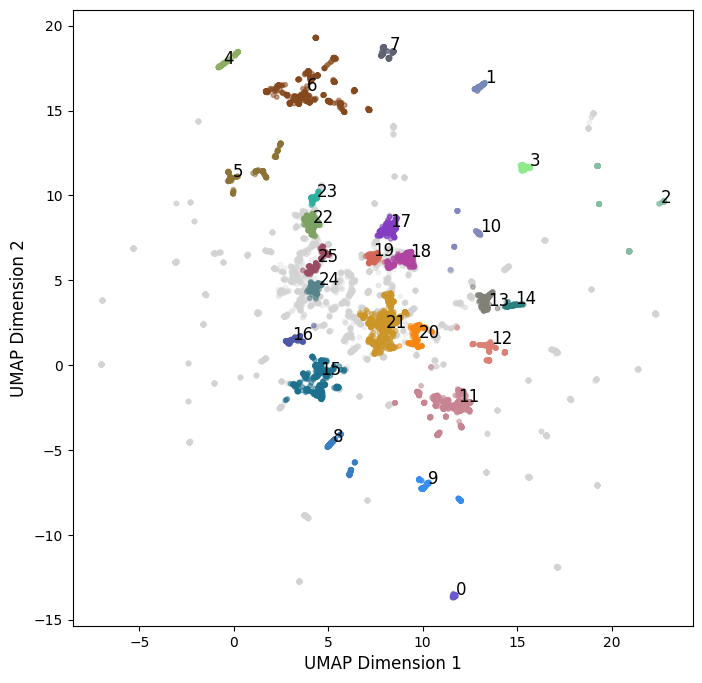

In [5]:
label = 'liver'

hdbscan = hdbs_dict[label]
proj = umap_dict[label]

# get unique cluster indices
c_labels = np.sort(np.unique(hdbscan.labels_))
n_c = len(c_labels)

# create a custom segmented colormap
cmap = mpl.colors.LinearSegmentedColormap.from_list("", 
    ["slateblue", "lightgreen", "saddlebrown", "dodgerblue",  
     "salmon", "teal",  "darkorchid", "darkorange", 
     "lightseagreen", "crimson"]
)

# define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0,n_c,n_c+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(8,8))

# plot noise points as light gray
c_idx_noise = np.where(hdbscan.labels_ == -1)[0]
c_idx_noise_labels = hdbscan.labels_[c_idx_noise]
proj_c_noise = proj[c_idx_noise,:]
scat = ax.scatter(proj_c_noise[:,0], proj_c_noise[:,1], alpha=0.25,
                  color='lightgray', s=10)

# plot cluster points
c_idx = np.where(hdbscan.labels_ != -1)[0]
c_idx_labels = hdbscan.labels_[c_idx]
proj_c = proj[c_idx,:]
scat = ax.scatter(proj_c[:,0], proj_c[:,1], alpha=0.5, c=c_idx_labels,
                  cmap=cmap, norm=norm, s=10)


# place cluster label at cluster mediod position
for i in range(hdbscan.medoids_.shape[0]):
    medoid_idx = hdbscan.medoids_[i,:]
    ax.text(medoid_idx[0]+0.1, medoid_idx[1]+0.1, i, fontsize=12)

ax.set_xlabel('UMAP Dimension 1', fontsize=12)
ax.set_ylabel('UMAP Dimension 2', fontsize=12)


# ax.legend()
plt.savefig('umap.png', transparent=True)

## 4.2 Print phrases belonging to each cluster

In [49]:
clus = 15
ent_text = phrase_dict[label]
clus_idx = np.where(hdbscan.labels_ == clus)[0]
for i in clus_idx:
    print(ent_text[i][1])

The liver is a multifunctional organ, which undergoes rapid changes
The liver is a unique organ that has a great ability
The liver is an organ of paramount importance, which plays an essential role
The liver is a critical organ
The liver is a dynamic organ
The liver is a complex organ
the liver is a heterogeneous tissue
the liver is an elastic organ and could be deformed between catheter implantation
the liver is a relatively large organ
The liver is the largest internal organ and provides
The liver is an important organ that has an abundance of mitochondria
The liver is a versatile organ which plays an important role
The liver is the most frequent site of involvement among the internal viscera
The liver is a highly specialized and complex organ and the development of in vitro systems that reflects this complexity
The liver is a complex organ where various cell types reside and interact in close vicinity
the liver is a larger sequestering organ
The liver is the site of many biochemical

## 4.3 Supplementary Table 1 - Journal by Cluster Counts

In [14]:
# load in all article metadata
articles = json.load(open('data/matched_articles.json', 'rb'))
# json is a list of dictionaries, re-index each article with doi to create global dictionary
articles = {a['doi']: a for a in articles}
# pull the doi from each expression
doi_list = [e[0] for e in phrase_dict['brain']]
# hdbscan results for 'brain'
hdbscan = hdbs_dict['brain']


In [22]:
# create Pandas dataframe for easy manipulation
clus_df = pd.DataFrame({
    'doi': doi_list,
    'journal': [articles[d]['journal'] for d in doi_list],
    'clus': hdbscan.labels_,
    'year': [articles[d]['publication_year'] if 'publication_year' in articles[d] 
             else np.NaN 
             for d in doi_list]
})

# filter out journals w/ infrequent articles (< 20)
clus_df['journal_n'] = clus_df.groupby('journal')['doi'].transform('count')
clus_df =  clus_df.loc[clus_df.journal_n >= 20].copy()

# define cluster label descriptions 
# these labels will be non-applicable if cluster params or random seed is changed
clus_labels = {
    0: 'cholesterol-rich',
    2: 'metastasis',
    3: 'most-complex-organ',
    5: 'immune-priveleged',
    6: 'lipid rich',
    7: 'heterogenous-organ',
    8: 'energy-demanding',
    9: 'oxygen-demanding',
    10: 'stress-adaptation',
    11: 'system-neurons',
    12: 'information-processor',
    13: 'prediction-machine',
    14: 'steroidogenic',
    15: 'complex-network',
    16: 'non linear-system',
    17: 'adaptive-plastic',
    18: 'complex-dynamic-system',
    19: 'complex-dynamic-system',
    20: 'oxidative-stress',
    21: 'toxicity',
    24: 'control-system'
}

# filter to selected clusters
selected_clus = list(clus_labels.keys())
clus_df = clus_df.loc[clus_df.clus.isin(selected_clus)].copy()

clus_df['clus_label'] = clus_df.clus.replace(clus_labels)

# shorten these journal names
j_short = {
    'International Journal of Environmental Research and Public Health': \
    'I.J. of Environmental Research and Public Health',
    'Evidence-based Complementary and Alternative Medicine : eCAM': 'eCAM'
}
clus_df['journal'] = clus_df.journal.replace(j_short)

# calculate crosstab
cj_ct = pd.crosstab(clus_df['journal'], clus_df['clus_label'])

In [38]:
clus_count = {clus_labels[c]: 0 for c in clus_labels}
for i in np.unique(hdbscan.labels_):
    if i in clus_labels:
        clus_count[clus_labels[i]] += (hdbscan.labels_ == i).sum()
clus_count

{'cholesterol-rich': 67,
 'metastasis': 111,
 'most-complex-organ': 157,
 'immune-priveleged': 156,
 'lipid rich': 71,
 'heterogenous-organ': 257,
 'energy-demanding': 461,
 'oxygen-demanding': 68,
 'stress-adaptation': 61,
 'system-neurons': 74,
 'information-processor': 107,
 'prediction-machine': 83,
 'steroidogenic': 65,
 'complex-network': 277,
 'non linear-system': 65,
 'adaptive-plastic': 67,
 'complex-dynamic-system': 301,
 'oxidative-stress': 96,
 'toxicity': 62,
 'control-system': 160}

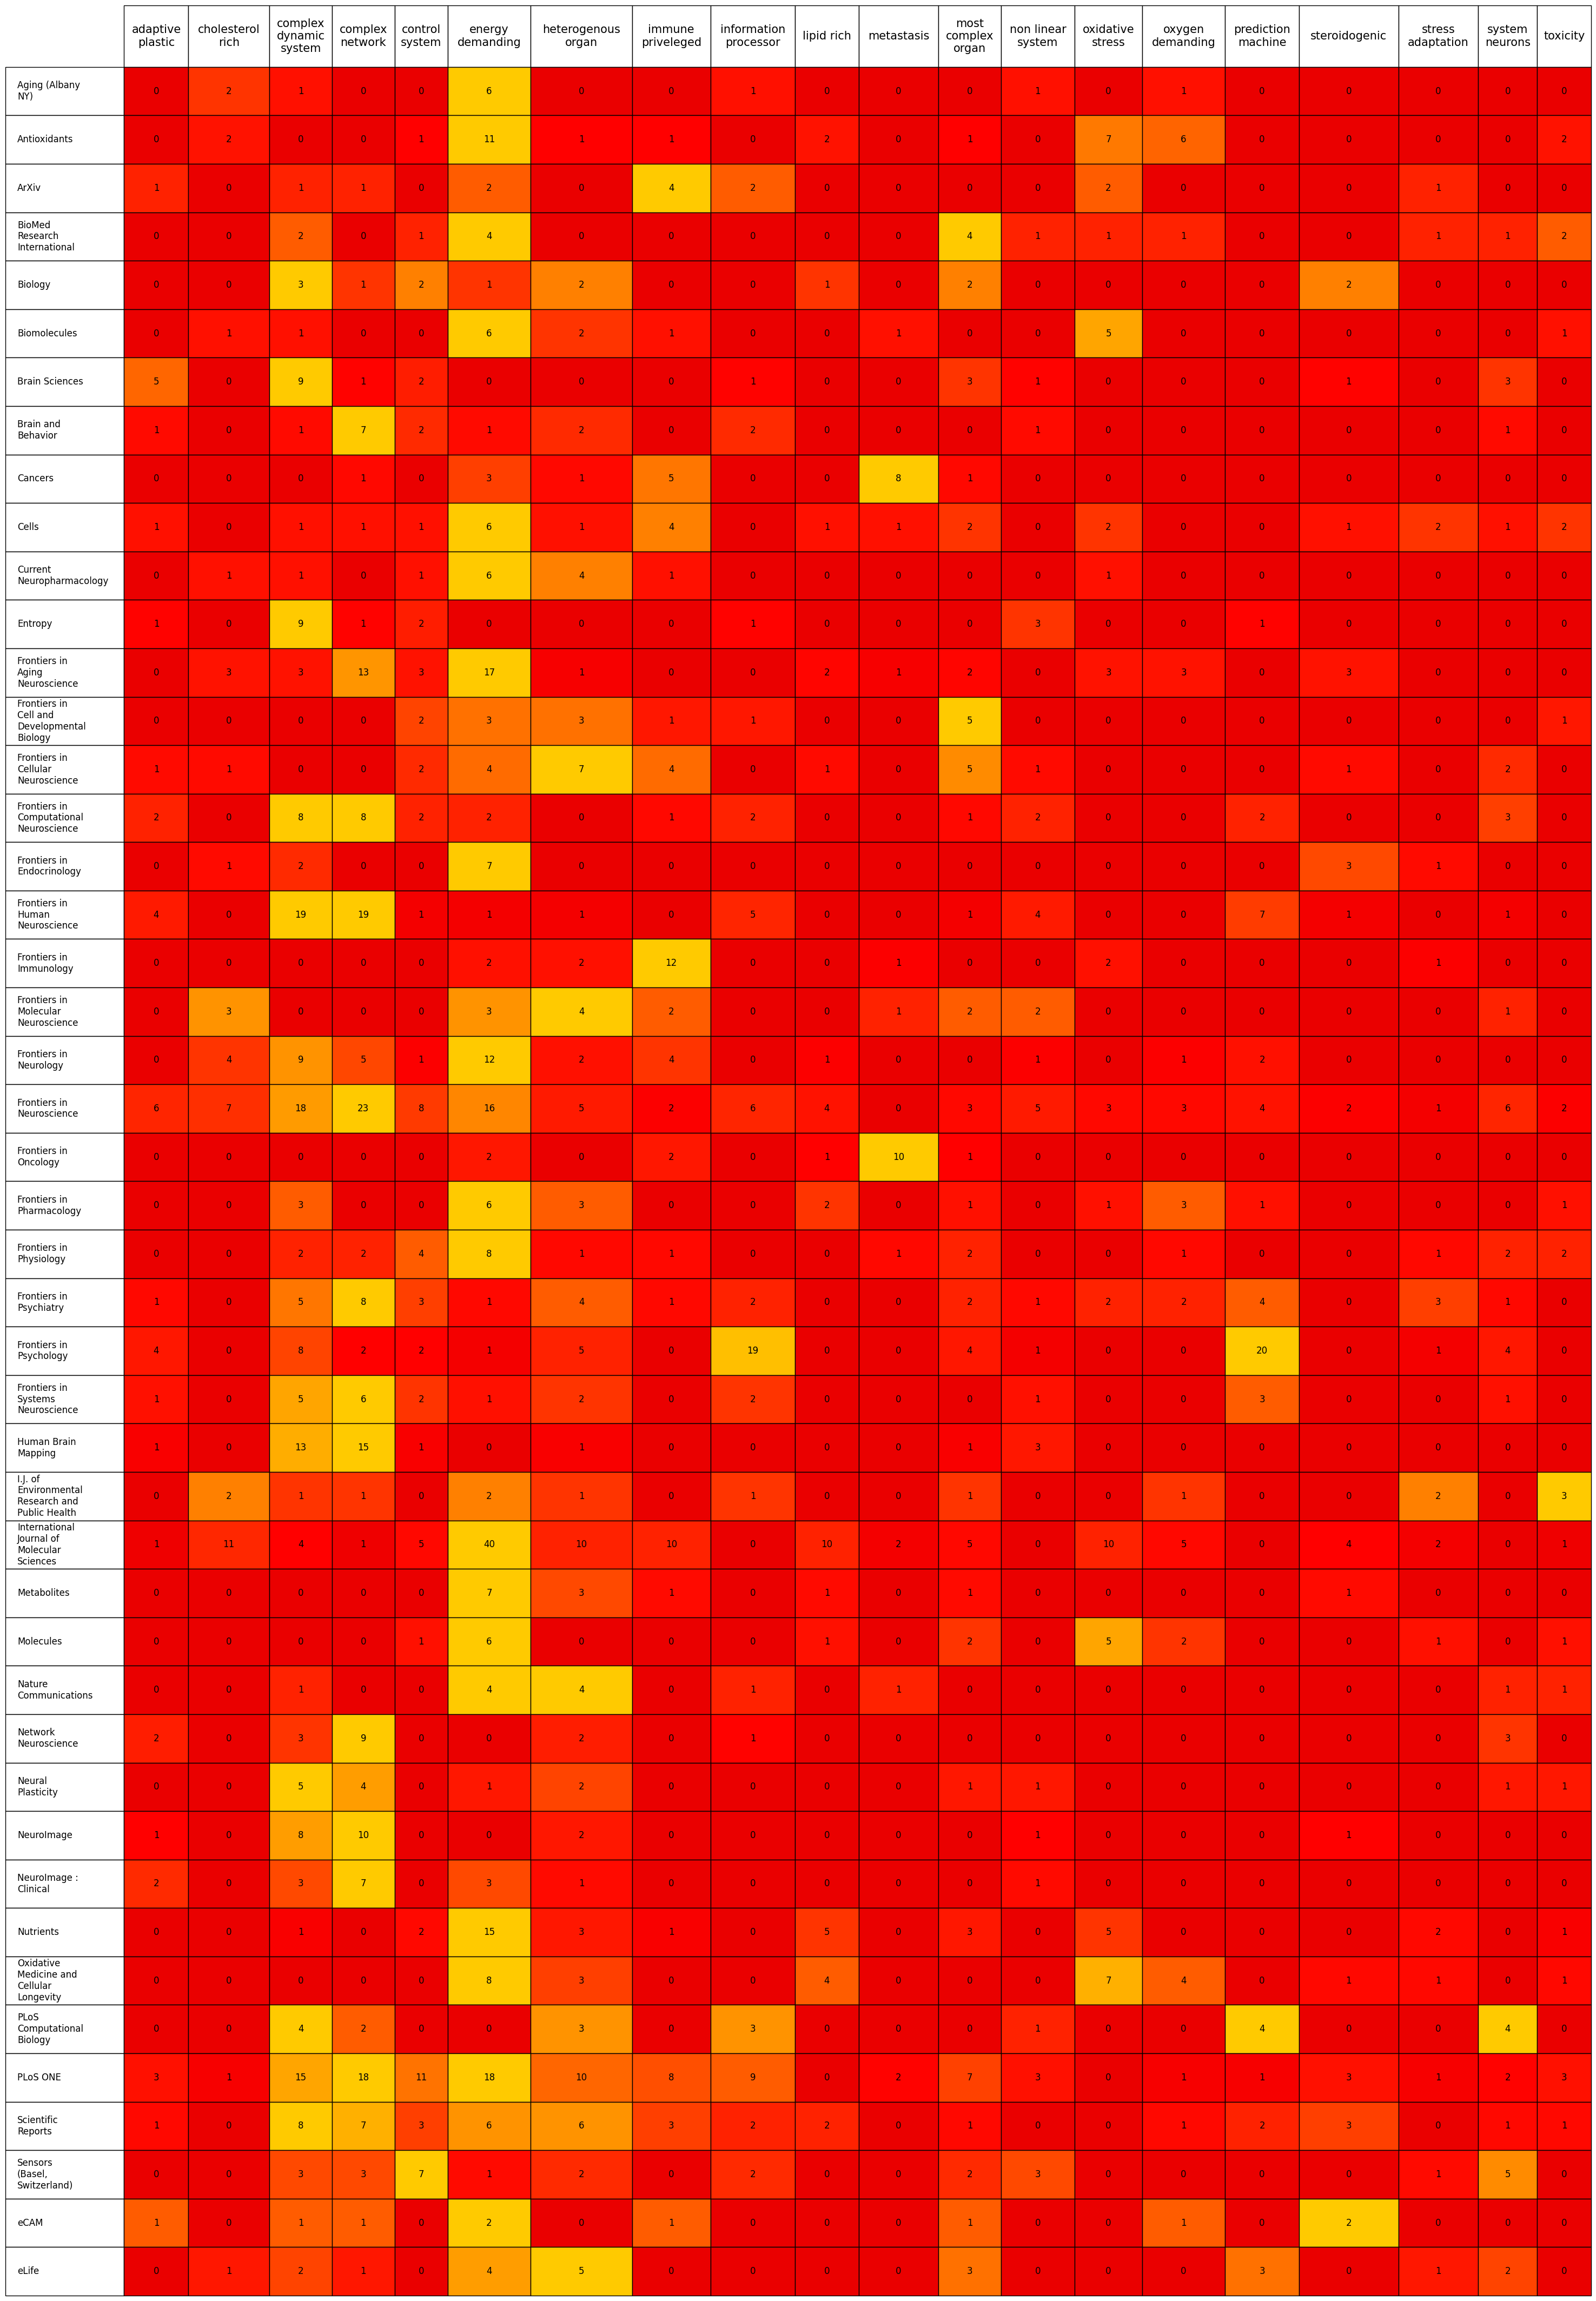

In [45]:
cj_ct_norm=cj_ct.sub(cj_ct.min(axis=1), axis=0).div((cj_ct.max(axis=1)-cj_ct.min(axis=1)), axis=0)

norm = plt.Normalize(cj_ct_norm.values.min()-1, cj_ct_norm.values.max()+1)
colours = plt.cm.hot(norm(cj_ct_norm.values))

fig, ax = plt.subplots(figsize=(35,55))
ax.axis('off')

# create new lines to fit text labels in cells
wrapper = textwrap.TextWrapper(width=14, break_long_words=False)
j_newline = [wrapper.fill(text=j) for j in cj_ct.index]
c_newline = [c.replace('-', '\n').replace('_', '\n') for c in cj_ct.columns]


table = ax.table(
    cellText=cj_ct.values, rowLabels=j_newline, 
    colLabels=c_newline, colWidths = [0.01]*cj_ct.shape[1], 
    cellColours=colours, cellLoc='center', bbox=[0, 0, 1, 1]
)

table.auto_set_font_size(False)
table.set_fontsize(12)
# table.scale(2, 2)

cells = table._cells
for cell in table._cells:
    if cell[0] == 0:
        table._cells[cell].set_fontsize(15)
        table._cells[cell].set_height(0.005)
    elif cell[1] == -1:
        table._cells[cell].set_fontsize(12)
        
table.auto_set_column_width(col=list(range(len(cj_ct.columns))))
plt.show()


## 4.4 Article Sections

In [32]:

articles_brain = {doi: articles[doi] for doi in doi_list}
section_label = []
for id in articles_brain:
    a = articles[id]
    if 'text' in a:
        for t in a['text']:
            if any([s in a['text'][t] for s in a['matched_sent']]):
                section_label.append(t.strip().lower())
    else:
        section_label.append('abstract')


section_label = [re.sub("[0-9,.:;?!\"' ]",'', s) for s in section_label]
standard_sections = ['result', 'introduction', 'method', 'materials', 'discussion', 
                     'conclusion' ,'background', 'abstract']
section_label_standard = [
    s for s in section_label 
    if any([std in s for std in standard_sections])
]

In [33]:
pd.Series(section_label).value_counts(normalize=True)

introduction                                                          0.323352
discussion                                                            0.132312
abstract                                                              0.094940
                                                                      0.032498
background                                                            0.022284
                                                                        ...   
predictionandpleasureinmusiclistening                                 0.000232
possiblemechanismforbehavioralterationsinlepakofish                   0.000232
oxidativestressandparkinson’sdisease                                  0.000232
identificationoflncrnasthatareexpressedduringmouseheartdevelopment    0.000232
definitionofdeath                                                     0.000232
Name: proportion, Length: 1607, dtype: float64

In [37]:
pd.Series(section_label_standard).value_counts(normalize=True)

introduction                                                                             0.539922
discussion                                                                               0.220930
abstract                                                                                 0.158527
background                                                                               0.037209
conclusion                                                                               0.006977
                                                                                           ...   
thesomaticgenetransfermethodallowsdose-dependentdetectionofthagonistsinbrainandmuscle    0.000388
conclusionandfutureperspectives                                                          0.000388
humanneuralstemcellsintroduction                                                         0.000388
resultanddiscussion                                                                      0.000388
caveatsandconclusion

In [216]:
text=[p[2] for p in phrases]
with open('matched_expressions.txt', 'w') as f:
    for line in text:
        line_filt = line.replace('\n', '')
        f.write(f"{line_filt}\n")

In [198]:
embed_dict['brain'].shape

(4375, 768)

In [214]:
text[305]

'The liver is a central metabolic organ in charge of                        regulating nutrient homeostasis in fed and fasting conditions'